In [1]:
from pandas import read_csv, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import plotly.graph_objects as go

import numpy as math
import matplotlib.pyplot as plot

In [2]:
X = read_csv('wino.csv')
y = X.pop('jakość')
K = X.columns
skróty = {
    'kwasowość': 'kw.',
    'lotna kwasowość': 'kw.lot',
    'kwas cytrynowy': 'kws.cyt.',
    'pozostały cukier': 'cuk.',
    'wolne chlorki': 'chl.',
    'dwutlenek siarki': 'SO2',
    'dwutlenek siarki całkowity': 'SO2-c.',
    'gęstość': 'gęst.',
    'siarczany': 'siar.',
    'alkohol': 'alk.',
    'pH': 'pH',
    'jakość': 'jak.',
    'czerwone': 'cz.'
}; K_s = [skróty[k] for k in K]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
M0 = DecisionTreeClassifier(random_state=42)
M0.fit(X, y);

## Ocena drzewa

Widać, że drzewo jest całkiem poprawne, jednak dużo z tego wynika z nierówności w grupach, co widać
na histogramie zmiennej `jakość`.

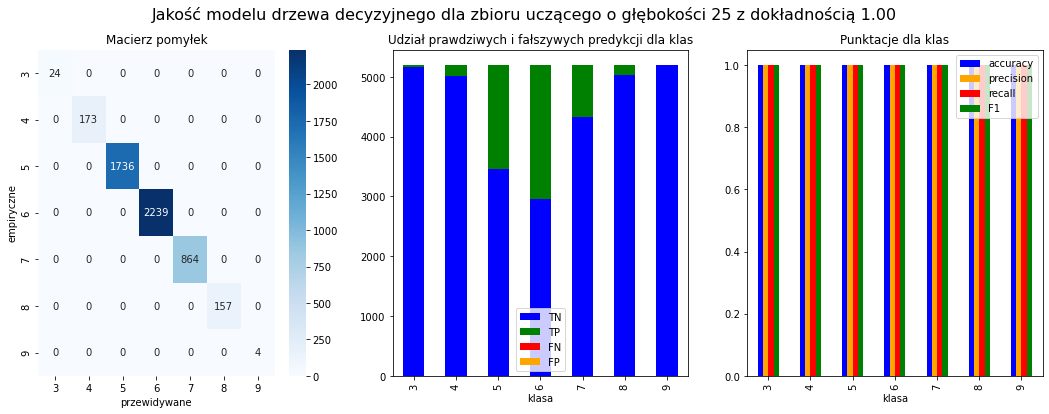

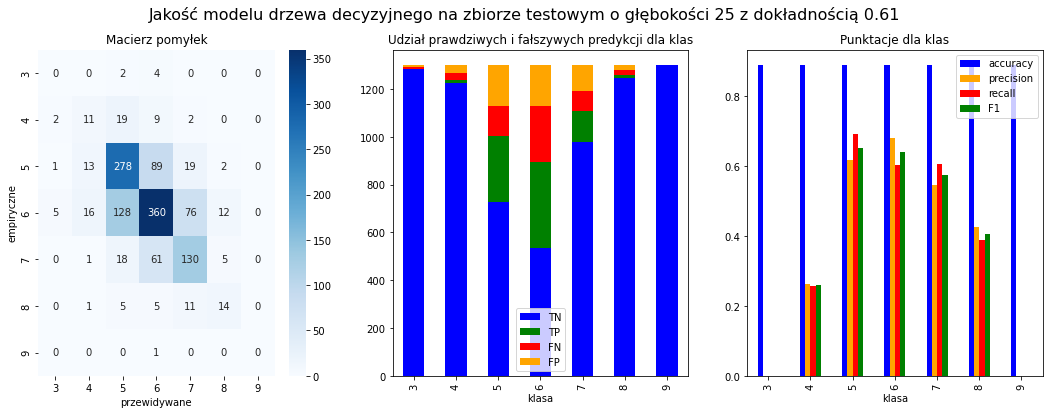

In [4]:
from seaborn import heatmap
from pandas import DataFrame
import matplotlib.pyplot as plot
def confusion_matrix_plot(matrix, ax=None):

    if ax is None:
        ax = plot.gca()
    heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('przewidywane')
    ax.set_ylabel('empiryczne')
    ax.set_title('Macierz pomyłek')

def confusion_matrix_stats(matrix, ax=None):

    true_positive = matrix.values.diagonal()
    false_positive = matrix.sum(axis=0) - true_positive
    false_negative = matrix.sum(axis=1) - true_positive
    true_negative = matrix.values.sum() - (true_positive + false_positive + false_negative)

    stats = DataFrame({
        'TN': true_negative,
        'TP': true_positive,
        'FN': false_negative,
        'FP': false_positive
    }, index=matrix.index)

    if ax is None:
        ax = plot.gca()

    colors = ['blue', 'green', 'red', 'orange']
    stats.plot.bar(ax=ax, color=colors, stacked=True)
    ax.set_title(f'Udział prawdziwych i fałszywych predykcji dla klas')
    ax.set_ylabel('')
    ax.set_xlabel('klasa')

    return stats

def confusion_matrix_scores(stats, index, ax=None):

    accuracy = (sum(stats.TP) + sum(stats.TN)) / stats.sum().sum()
    precision = stats.TP / (stats.TP + stats.FP)
    recall = stats.TP / (stats.TP + stats.FN)
    F1 = 2 * precision * recall / (precision + recall)

    precision.replace(math.nan, 0, inplace=True)
    recall.replace(math.nan, 0, inplace=True)
    F1.replace(math.nan, 0, inplace=True)

    scores = DataFrame({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': F1
    }, index=index)

    if ax is None:
        ax = plot.gca()

    colors = ['blue', 'orange', 'red', 'green']
    scores.plot.bar(ax=ax, color=colors)
    ax.set_title('Punktacje dla klas')
    ax.set_ylabel('')
    ax.set_xlabel('klasa')

def tree_quality_plot(X, y, M, title = 'Jakość modelu drzewa decyzyjnego'):

    score = accuracy_score(y, M.predict(X))

    fig, axes = plot.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title + f' o głębokości {M.get_depth()}' + f' z dokładnością {score:.2f}', fontsize=16)

    matrix = confusion_matrix(y, M.predict(X))
    matrix = DataFrame(matrix, index=M.classes_, columns=M.classes_)

    confusion_matrix_plot(matrix, ax=axes[0])
    axes[0].set_title(axes[0].get_title())
    stats = confusion_matrix_stats(matrix, ax=axes[1])
    scores = confusion_matrix_scores(stats, index=M.classes_)

tree_quality_plot(X, y, M0, title='Jakość modelu drzewa decyzyjnego dla zbioru uczącego')
tree_quality_plot(X_test, y_test, M0, title='Jakość modelu drzewa decyzyjnego na zbiorze testowym')

### Ograniczenie głębokości i kryterium alfa

Zbiór jest stanowczo za dobrze dopasowany do danych testowych

> Minimal cost-complexity pruning is an algorithm used to prune a tree to avoid
> over-fitting, described in Chapter 3 of [BRE]_. This algorithm is parameterized
> by $\alpha\ge0$ known as the complexity parameter. The complexity
> parameter is used to define the cost-complexity measure, $R_\alpha(T)$ of
> a given tree $T$:

$$
R_\alpha(T) = R(T) + \alpha|\widetilde{T}|
$$

Źródło cytatu: [Dokumentacja scikit-learn](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning)


Alfa wyszła najlepiej zerowa, a głebokość maksymalna 23, ale efekty ograniczenia są żadne

AttributeError: 'AxesSubplot' object has no attribute 'show'

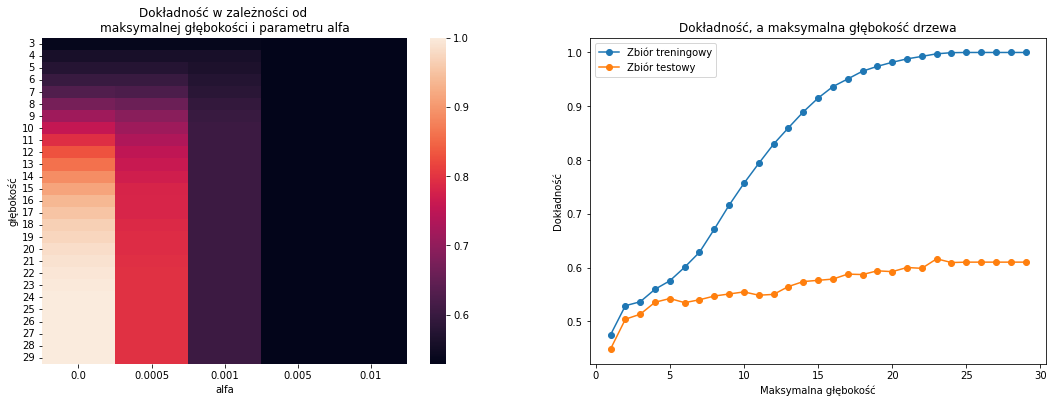

In [46]:
def accuracy_heatmap(X, y, depths, alphas, ax = None):

    scores = DataFrame(index=depths, columns=alphas)

    for d in depths:
        for a in alphas:
            model = DecisionTreeClassifier(random_state=42, max_depth=d, ccp_alpha=a)
            model.fit(X, y)
            scores.loc[d, a] = accuracy_score(y, model.predict(X))

    if ax is None:
        ax = plot.gca()

    heatmap(scores.astype(float), ax = ax)
    ax.set_title('Dokładność w zależności od \nmaksymalnej głębokości i parametru alfa')
    ax.set_xlabel('alfa')
    ax.set_ylabel('głębokość')


def plot_accuracy_vs_max_depth(X, y, X_test, y_test, max_depths, ax = None):
    accuracy_scores_train = []
    accuracy_scores_test = []

    for depth in max_depths:
        model = DecisionTreeClassifier(random_state=42, max_depth=depth)
        model.fit(X, y)
        accuracy_train = accuracy_score(y, model.predict(X))
        accuracy_test = accuracy_score(y_test, model.predict(X_test))
        accuracy_scores_train.append(accuracy_train)
        accuracy_scores_test.append(accuracy_test)

    if ax is None:
        ax = plot.gca()

    ax.plot(max_depths, accuracy_scores_train, marker='o', label='Zbiór treningowy')
    ax.plot(max_depths, accuracy_scores_test, marker='o', label='Zbiór testowy')
    ax.set_xlabel('Maksymalna głębokość')
    ax.set_ylabel('Dokładność')
    ax.set_title('Dokładność, a maksymalna głębokość drzewa')
    ax.legend()

fig, axes = plot.subplots(1, 2, figsize=(18, 6))

accuracy_heatmap(X, y, range(3,30), [0, 0.0005, 0.001, 0.005, 0.01], ax = axes[0])
plot_accuracy_vs_max_depth(X, y, X_test, y_test, range(1, 30), ax = axes[1])

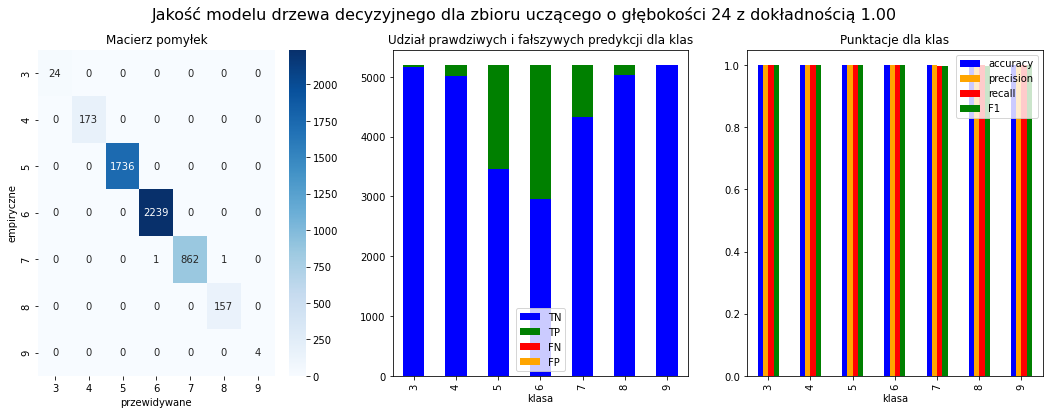

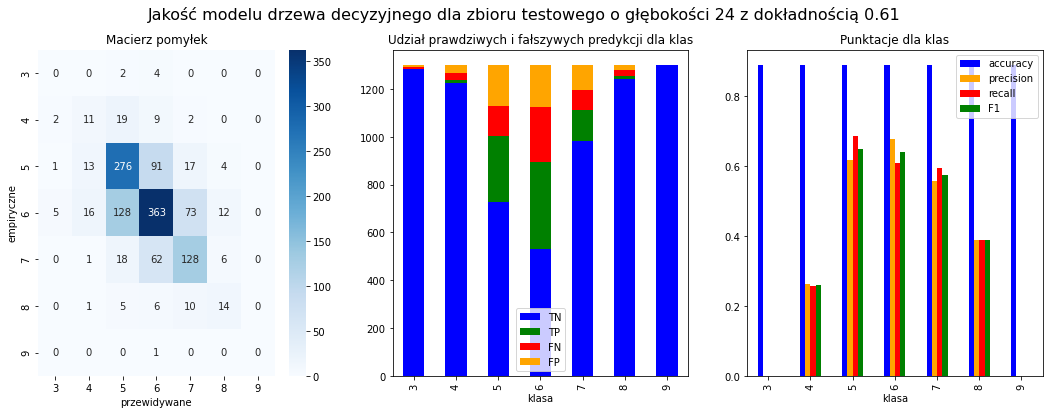

In [6]:
Mt = DecisionTreeClassifier(random_state=42, max_depth=24)
Mt.fit(X, y);
tree_quality_plot(X, y, Mt, title='Jakość modelu drzewa decyzyjnego dla zbioru uczącego')
tree_quality_plot(X_test, y_test, Mt, title='Jakość modelu drzewa decyzyjnego dla zbioru testowego')

## Poprawka na liczność grup

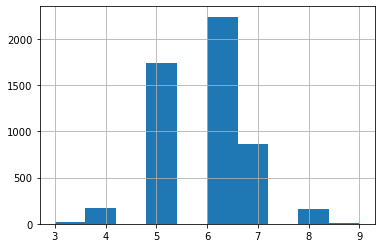

In [45]:
y.hist();

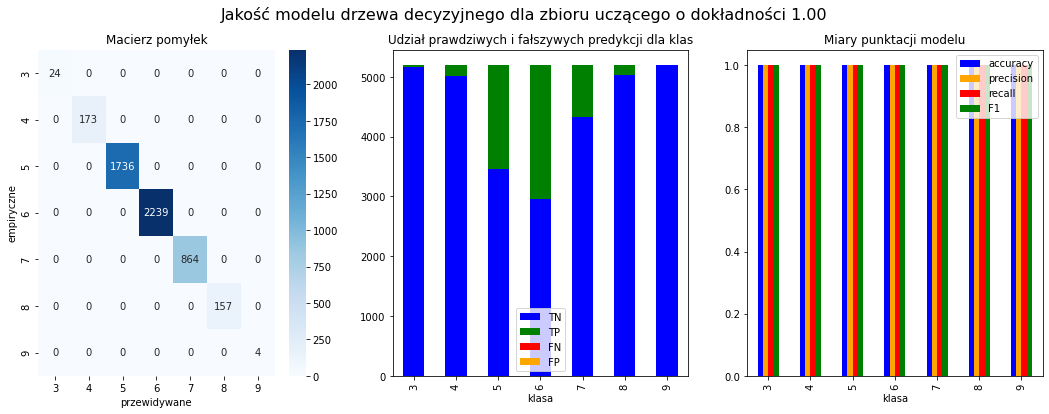

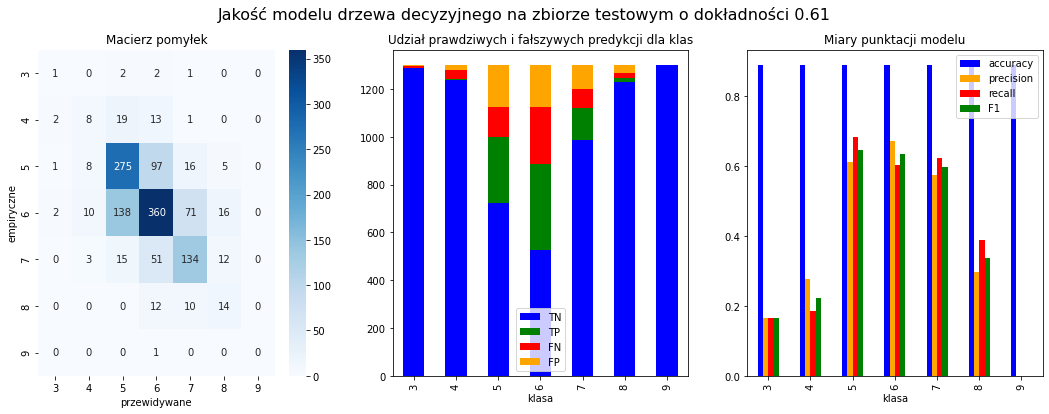

In [118]:
Mb = DecisionTreeClassifier(random_state=42, class_weight='balanced')
Mb.fit(X, y)

tree_quality_plot(X, y, Mb, title='Jakość modelu drzewa decyzyjnego dla zbioru uczącego')
tree_quality_plot(X_test, y_test, Mb, title='Jakość modelu drzewa decyzyjnego na zbiorze testowym')

In [53]:
DataFrame(y.value_counts()).T

,6,5,7,4,8,3,9
jakość,2239,1736,864,173,157,24,4
